In [ ]:
#Check correlation
#Undersample to obtain a balanced dataset and check if the model can correctly predict
#By feature selection, just drop those features
#Not just check precision and recall. Flip TP and check
#Answer what features are affecting precision and recall


In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
import xgboost
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [229]:
#Load the dataset 
dir = 'subsample_data'
data = pd.read_csv(dir,header=0)

## EDA

In [230]:
#Check data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 67 columns):
Unnamed: 0                                                          10000 non-null object
Unnamed: 1                                                          10000 non-null int64
Physician_License_State_code2                                       123 non-null object
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5           59 non-null object
Recipient_State                                                     9989 non-null object
Recipient_Country                                                   9993 non-null object
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1           8205 non-null object
Form_of_Payment_or_Transfer_of_Value                                10000 non-null object
Associated_Drug_or_Biological_NDC_4                                 102 non-null object
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_4           151 non-null object
Cover

In [231]:
#Split the datset into the targeted feature and predictive features
target = data['Target']
features = data.drop('Target', axis=1)


In [232]:
#Create a pairplot for all numeric features to see distribution trends and other important elements
numerics = features._get_numeric_data()

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


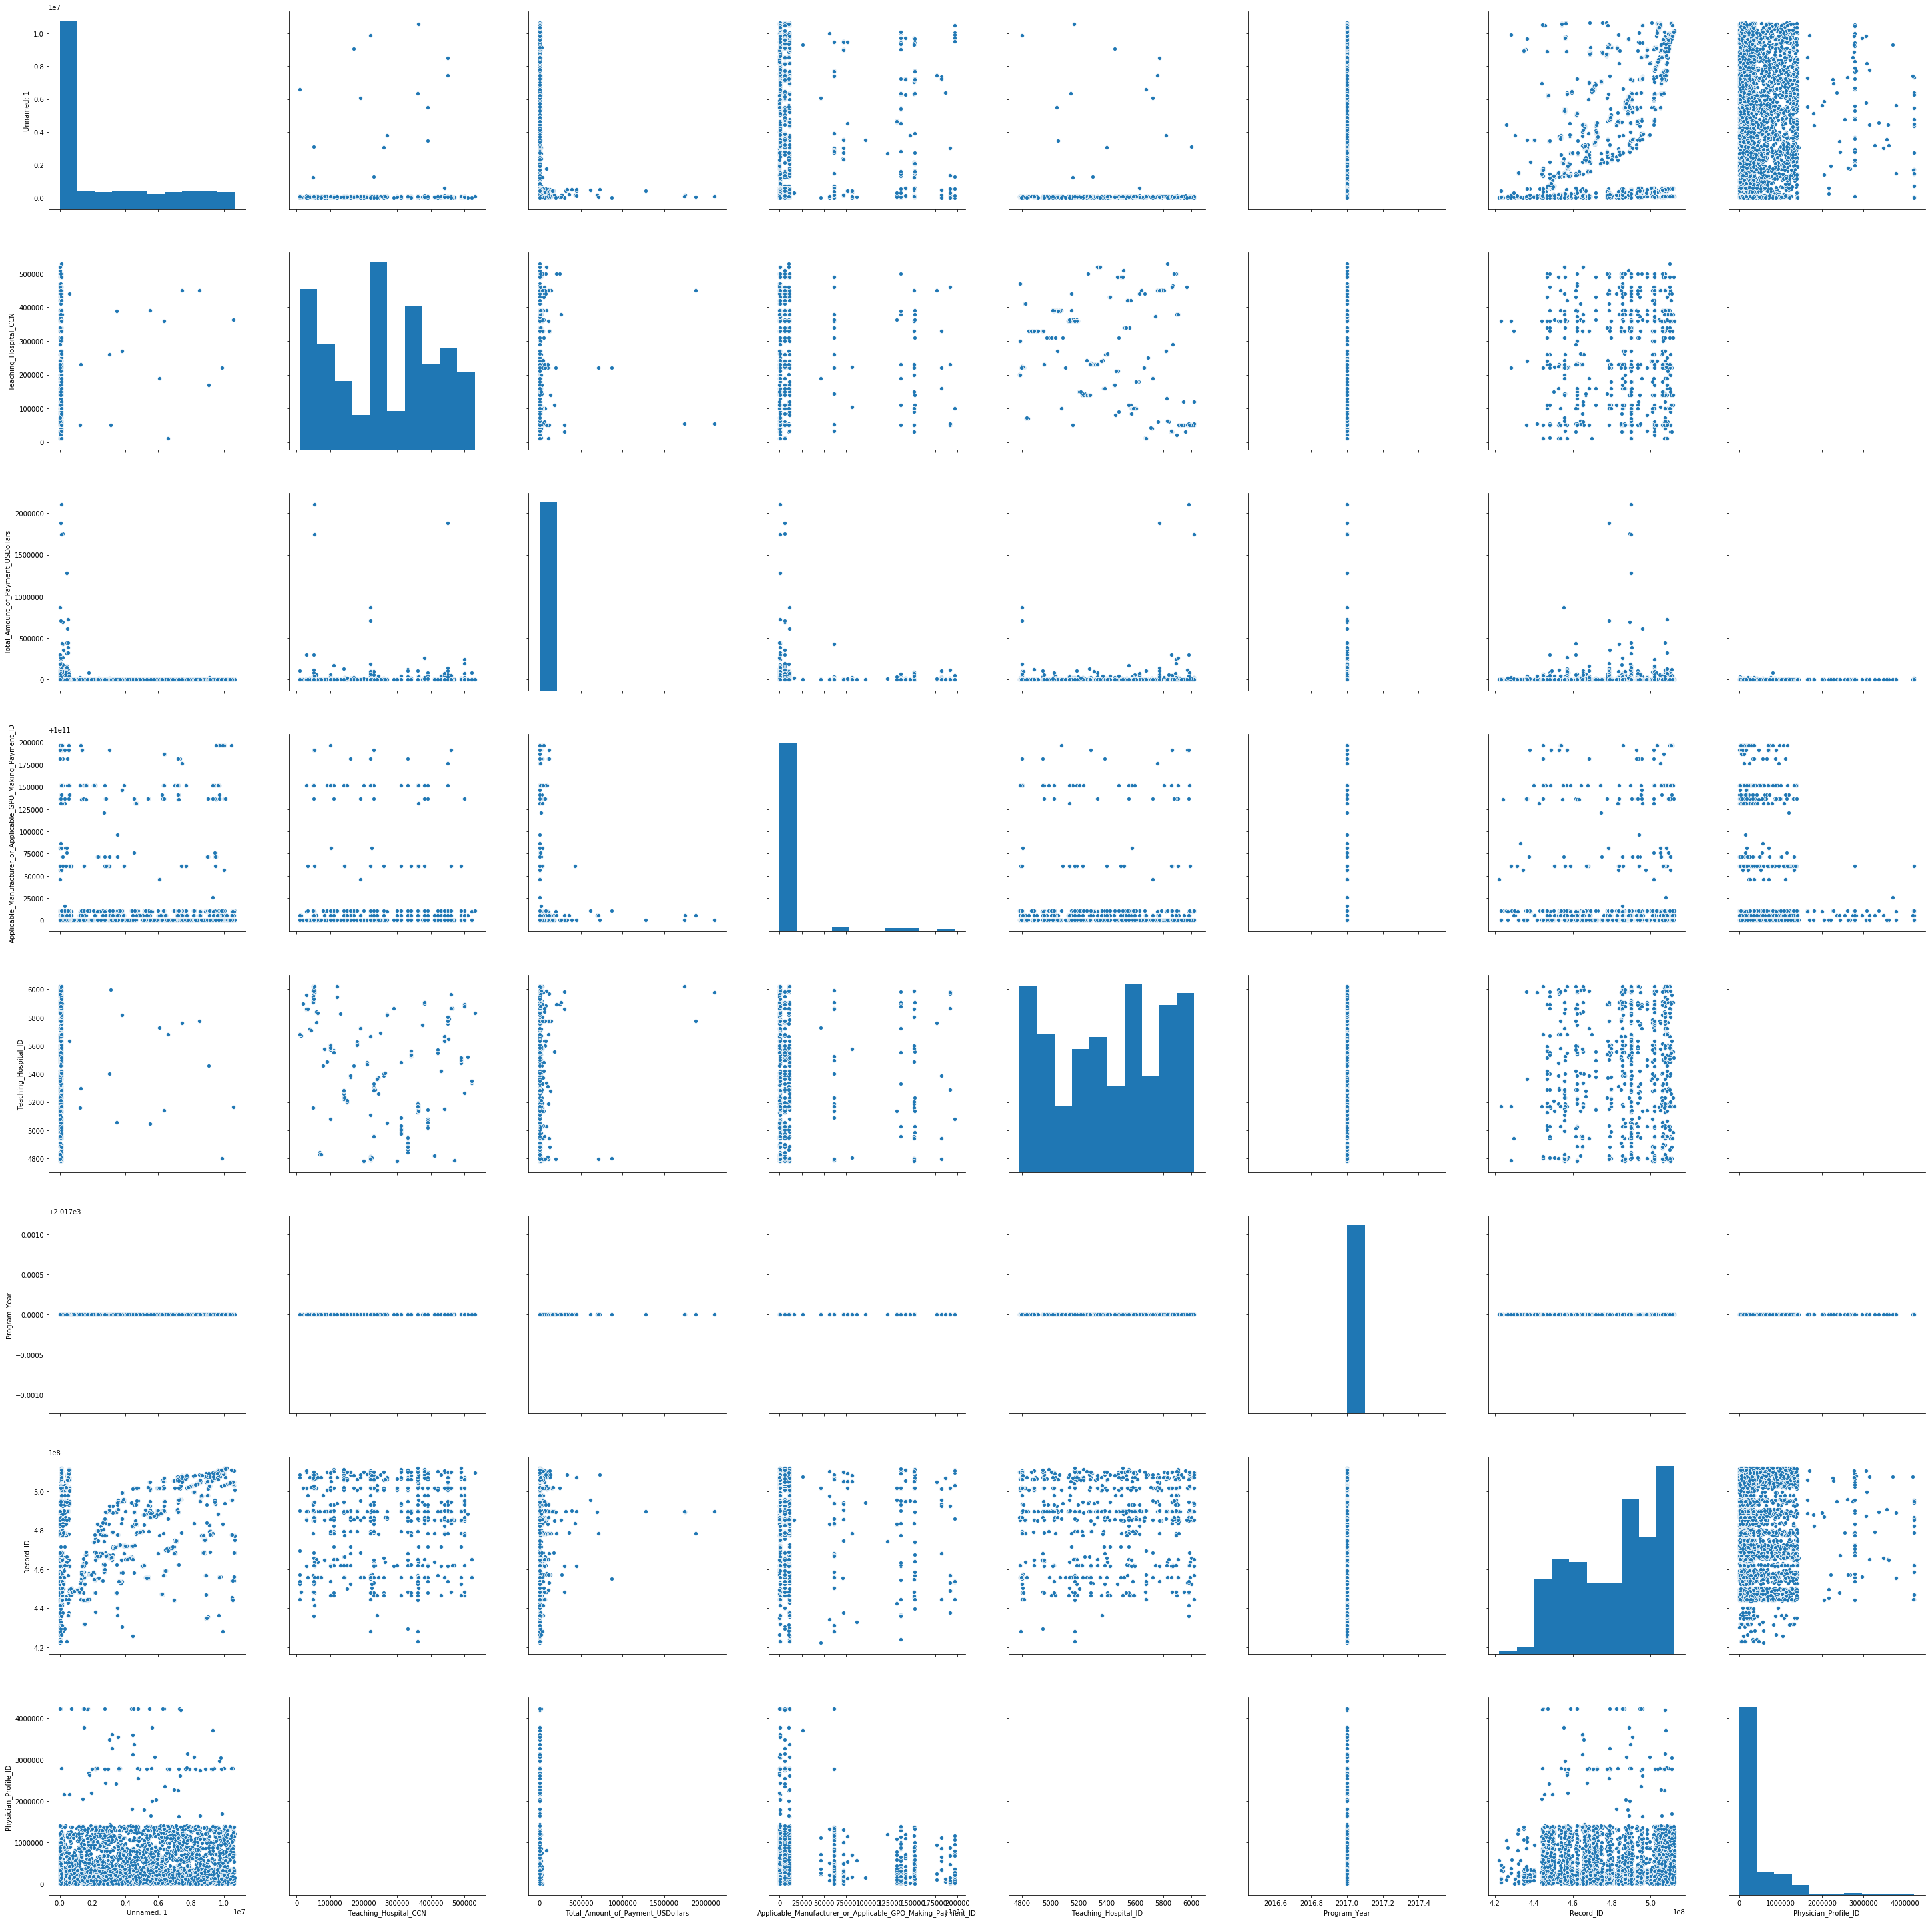

In [159]:
sns.pairplot(numerics,size=5)

## Baseline Model (Logistic Regression)

In [233]:
#Check the number of missing values of numeric features
num = numerics.isnull().sum()

#Extract columns which have fewer than 5000 nulls
num_name = []
for i in range(len(num)):
    if(num[i-1] < 5000):
        num_name.append(num.index.tolist()[i-1])
    else:
        continue
num_name = ['Total_Amount_of_Payment_USDollars','Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID','Program_Year','Physician_Profile_ID']
#Create the dataframe for numeric variables , create a new dataframe named num_name, and store each variable's name   
temp = data[num_name]
num_temp = temp[['Total_Amount_of_Payment_USDollars']]
num_name = list(num_temp)

In [234]:
#Store the list of names of numeric features
numeric_features = list(numerics)

In [235]:
#Extract categorical features and store the list of names of categorical features
categoricals = features.select_dtypes(include='object')
categorical_features = list(categoricals)

In [236]:
#Check the number of missing values of categorical features
categ = categoricals.isnull().sum()

#Extract columns which have fewer than 5000 nulls
categ_name = []
for i in range(len(categ)):
    if(categ[i-1] < 5000):
        categ_name.append(categ.index.tolist()[i-1])
    else:
        continue

#Create the dataframe for categorical variables, create a new dataframe named categ_name, and store each variable's name   
categ_temp = data[categ_name]
categ_name = list(categ_temp)

In [237]:
#Concatenate num_temp and categ_temp
new = pd.concat([num_temp,categ_temp],axis=1)
list(new)

['Total_Amount_of_Payment_USDollars',
 'Unnamed: 0',
 'Recipient_State',
 'Recipient_Country',
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
 'Form_of_Payment_or_Transfer_of_Value',
 'Physician_Specialty',
 'Date_of_Payment',
 'Recipient_City',
 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
 'Related_Product_Indicator',
 'Dispute_Status_for_Publication',
 'Recipient_Primary_Business_Street_Address_Line1',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
 'Delay_in_Publication_Indicator',
 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1',
 'Physician_First_Name',
 'Change_Type',
 'Payment_Publication_Date',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
 'Recipient_Zip_Code',
 'Physician_Primary_Type',
 'Physician_License_State_code1',
 'Physician_Last_Name',
 'Associated_Drug_or_Biological_NDC_1',
 'Covered_Recipient_Type',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
 'Product_Categor

In [10]:
#Build a pipeline to handle the numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                    ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to the given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name)])

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',LogisticRegression())])

#Split the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(new, target, stratify=target, test_size=0.3)

#Cross validation 
scores = cross_val_score(clf,X_train, y_train, cv=5)
scores = sum(scores) / float(len(scores))
print("Baseline Logistic Regression:")
print(scores)



Baseline Logistic Regression:
0.9998571428571429


## Model 2 (Ridge Regression)

In [32]:
#Build a pipeline to handle the numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                    ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RidgeClassifier())])

X_train, X_test, y_train, y_test = train_test_split(features, target, stratify=target, test_size=0.3)

param_grid = {'classifier__alpha': [0.01,0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(clf, param_grid=param_grid, cv=5)
ridge_grid.fit(X_train, y_train)

print("best mean cross-validation score of Ridge Regression: {:.3f}".format(ridge_grid.best_score_))
print("best parameters of Ridge Regression: {}".format(ridge_grid.best_params_))
print("test-set score of Ridge Regression: {:.3f}".format(ridge_grid.score(X_test, y_test)))
print("")


# #Cross validation 
# scores = cross_val_score(clf,X_train, y_train, cv=10)
# scores = sum(scores) / float(len(scores))
# print("Ridge Classifier:")
# print(scores)



best mean cross-validation score of Ridge Regression: 1.000
best parameters of Ridge Regression: {'classifier__alpha': 0.01}
test-set score of Ridge Regression: 1.000



In [165]:
from copy import deepcopy
from sklearn.metrics import roc_auc_score, precision_score

above_98 = ['Unnamed: 0','Physician_Specialty','Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
    'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1','Physician_First_Name','Physician_Primary_Type',
            'Physician_License_State_code1','Physician_Last_Name','Associated_Drug_or_Biological_NDC_1','Covered_Recipient_Type',
            'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name', 'Product_Category_or_Therapeutic_Area_1']
rec_details = ['Recipient_City','Recipient_Primary_Business_Street_Address_Line1',
              #'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country','Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
              'Recipient_Zip_Code']
new_remove = ['Date_of_Payment']
num_name = ['Total_Amount_of_Payment_USDollars']
categ_name_copy = deepcopy(categ_name)
remove_list = above_98 + new_remove +  rec_details
for a in remove_list:
    if a in categ_name_copy:
        categ_name_copy.remove(a)

#print(categ_name_copy)
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to the given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name_copy)])

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RidgeClassifier())])

#Split the dataset into the training set and test set
#X_train, X_test, y_train, y_test = train_test_split(new, target, stratify=target, test_size=0.3)

# param_grid = {'classifier__alpha': [0.01,0.1, 1, 10, 100]}
# ridge_grid = GridSearchCV(clf, param_grid=param_grid, cv=5)
# ridge_grid.fit(X_train, y_train)

# print("best mean cross-validation score of Ridge Regression: {:.3f}".format(ridge_grid.best_score_))
# print("best parameters of Ridge Regression: {}".format(ridge_grid.best_params_))
# print("test-set score of Ridge Regression: {:.3f}".format(ridge_grid.score(X_test, y_test)))
# print("")

# ridge = RidgeClassifier(alpha=ridge_grid.best_params_['classifier__alpha'])
# final_pipe = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', ridge)])
#final_pipe.fit(X_train, y_train)
# y_pred = final_pipe.predict(X_test)
# cm = confusion_matrix(y_test, y_pred)
# print("Confusion Metrix:")
# print(cm)
# print("")
# print("ROC AUC score:" )
# print(roc_auc_score(y_test, y_pred))
# print("")
# print("Precision Score:")
# print(precision_score(y_test, y_pred))
clf.fit(new,target)


#preprocessor.fit_transform(X_train)

# Cross validation 
# scores = cross_val_score(clf,X_train, y_train, cv=5)
# scores = sum(scores) / float(len(scores))
# print("Baseline Logistic Regression :",scores)



Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbo...True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001))])

In [158]:
np.sort(np.absolute(ridge_grid.best_estimator_.named_steps['classifier'].coef_))

array([[1.26364271e-04, 1.27643563e-04, 1.55158800e-04, ...,
        8.35518166e-01, 9.95578151e-01, 1.05510961e+00]])

In [ ]:
ridge_grid.best_estimator_.named_steps['classifier'].coef_.shape

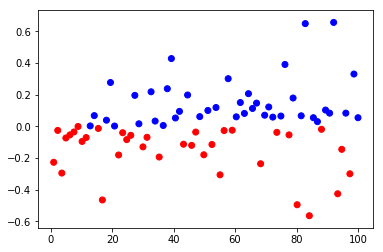

In [169]:
plt.scatter(np.linspace(1,100,76),ridge_grid.best_estimator_.steps[1][1].coef_,c=np.sign(ridge_grid.best_estimator_.steps[1][1].coef_), cmap="bwr_r")


In [171]:
final_pipe.named_steps['preprocessor'].transformers_[1][1].named_steps.onehot.get_feature_names(categ_name_copy)[:54]

array(['Recipient_State_AK', 'Recipient_State_AL', 'Recipient_State_AP',
       'Recipient_State_AR', 'Recipient_State_AZ', 'Recipient_State_CA',
       'Recipient_State_CO', 'Recipient_State_CT', 'Recipient_State_DC',
       'Recipient_State_DE', 'Recipient_State_FL', 'Recipient_State_GA',
       'Recipient_State_HI', 'Recipient_State_IA', 'Recipient_State_ID',
       'Recipient_State_IL', 'Recipient_State_IN', 'Recipient_State_KS',
       'Recipient_State_KY', 'Recipient_State_LA', 'Recipient_State_MA',
       'Recipient_State_MD', 'Recipient_State_ME', 'Recipient_State_MI',
       'Recipient_State_MN', 'Recipient_State_MO', 'Recipient_State_MS',
       'Recipient_State_MT', 'Recipient_State_NC', 'Recipient_State_ND',
       'Recipient_State_NE', 'Recipient_State_NH', 'Recipient_State_NJ',
       'Recipient_State_NM', 'Recipient_State_NV', 'Recipient_State_NY',
       'Recipient_State_OH', 'Recipient_State_OK', 'Recipient_State_OR',
       'Recipient_State_PA', 'Recipient_State_PR', 

## Model 3 (Random Forest)

In [239]:
from sklearn.svm import LinearSVC,SVC
from sklearn.linear_model import Lasso,RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score

# from copy import deepcopy
# above_98 = ['Unnamed: 0','Physician_Specialty','Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
#     'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1','Physician_First_Name','Physician_Primary_Type',
#             'Physician_License_State_code1','Physician_Last_Name','Associated_Drug_or_Biological_NDC_1','Covered_Recipient_Type',
#             'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name', 'Product_Category_or_Therapeutic_Area_1']
# rec_details = ['Recipient_City','Recipient_Primary_Business_Street_Address_Line1',
#               #'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country','Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
#               'Recipient_Zip_Code']
# new_remove = ['Date_of_Payment']
# num_name = ['Total_Amount_of_Payment_USDollars']
# num_name = []
# categ_name_copy = deepcopy(categ_name)
# remove_list = above_98 + new_remove +  rec_details
# for a in remove_list:
#     if a in categ_name_copy:
#         categ_name_copy.remove(a)

# print(categ_name_copy)

#X_train, X_test, y_train, y_test = train_test_split(features, target, stratify=target, test_size=0.3,shuffle=True)

#Build a pipeline to handle the numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                    ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name_copy)])

# param_grid = {'classifier__n_estimators': range(50, 300, 50),
#              'classifier__max_depth' : range(1,10)}

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(max_depth=9,n_estimators=200,random_state=0))])

# grid = GridSearchCV(clf, param_grid,cv=10, scoring='roc_auc')
# grid.fit(X_train, y_train)

# print('Score', grid.best_score_)
# print('Best params',grid.best_params_)


# rfc = RandomForestClassifier(n_estimators=grid.best_params_['classifier__n_estimators'],
#                                max_depth=grid.best_params_['classifier__max_depth'],random_state=0)
# final_pipe = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', rfc)])
# final_pipe.fit(X_train, y_train)
# y_pred = final_pipe.predict(X_test)
# cm = confusion_matrix(y_test, y_pred)
# print(cm)
# print(roc_auc_score(y_test, y_pred))

clf.fit(new,target)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose...mators=200, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [238]:
numeric_features

['Unnamed: 1',
 'Teaching_Hospital_CCN',
 'Total_Amount_of_Payment_USDollars',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
 'Teaching_Hospital_ID',
 'Program_Year',
 'Record_ID',
 'Physician_Profile_ID']

In [212]:
list(new)

['Total_Amount_of_Payment_USDollars',
 'Unnamed: 0',
 'Recipient_State',
 'Recipient_Country',
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
 'Form_of_Payment_or_Transfer_of_Value',
 'Physician_Specialty',
 'Date_of_Payment',
 'Recipient_City',
 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
 'Related_Product_Indicator',
 'Dispute_Status_for_Publication',
 'Recipient_Primary_Business_Street_Address_Line1',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
 'Delay_in_Publication_Indicator',
 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1',
 'Physician_First_Name',
 'Change_Type',
 'Payment_Publication_Date',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
 'Recipient_Zip_Code',
 'Physician_Primary_Type',
 'Physician_License_State_code1',
 'Physician_Last_Name',
 'Associated_Drug_or_Biological_NDC_1',
 'Covered_Recipient_Type',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
 'Product_Categor

## Model 4 (Logistic Regression)

In [182]:
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to the given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name_copy)])

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(C=0.01))])

#Split the dataset into the training set and test set
# X_train, X_test, y_train, y_test = train_test_split(new, target, stratify=target, test_size=0.3)

# param_grid = {'classifier__C': [0.01,0.1, 1, 10, 100]}

# logistic_grid = GridSearchCV(clf, param_grid=param_grid, cv=5)
# logistic_grid.fit(X_train, y_train)

# print("best mean cross-validation score of Ridge Regression: {:.3f}".format(ridge_grid.best_score_))
# print("best parameters of Ridge Regression: {}".format(ridge_grid.best_params_))
# print("test-set score of Ridge Regression: {:.3f}".format(ridge_grid.score(X_test, y_test)))
# print("")

# logistic = LogisticRegression(C=logistic_grid.best_params_['classifier__C'])
# final_pipe = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', logistic)])
# final_pipe.fit(X_train, y_train)
# y_pred = final_pipe.predict(X_test)
# cm = confusion_matrix(y_test, y_pred)
# print("Confusion Metrix:")
# print(cm)
# print("")
# print("ROC AUC score:" )
# print(roc_auc_score(y_test, y_pred))
# print("")
# print("Precision Score:")
# print(precision_score(y_test, y_pred))
clf.fit(new,target)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbo...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [25]:
np.argsort(np.absolute(logistic_grid.best_estimator_.named_steps['classifier'].coef_))

array([[  2,  46,  43,  14,  62,  22,  35,  48,  53,  45, 111,  16,   6,
         37,  20,  93,   4,   7,  12,  58,  68,  44,   8,  31,  21,  56,
        117,  66, 124,   5,  61,  50,  40,  18,  38, 115,  11,   1,  36,
         26,   9,  27,  41,  15,  67,  24,  10,  23,  33,  47,  28,  60,
         25, 102,  39,  69,  63,  86,  74, 105,  17,  42,  97, 109,  83,
         87,  34,  19, 113, 119,  32,  51,  30, 107, 118,  91,  29,  90,
         95,  85, 104,  80,  84, 103,  65,  99,  92,  49,  59, 122,  98,
         82,  13, 120,  89,   3, 112, 114, 100, 106,  57,  75, 123, 108,
         64,  94,  55, 121,  54,  78,  52, 116,  96,  71,  72, 110,  73,
         81,  77,  88,  76,  70,  79, 101,   0]])

In [29]:
logistic_grid.best_estimator_.named_steps['classifier'].coef_.shape

(1, 125)

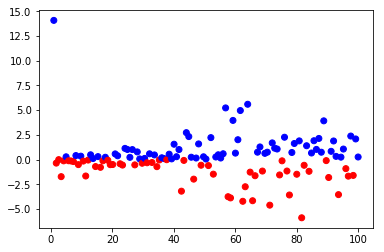

In [30]:
plt.scatter(np.linspace(1,100,125),logistic_grid.best_estimator_.steps[1][1].coef_,c=np.sign(logistic_grid.best_estimator_.steps[1][1].coef_), cmap="bwr_r")

In [31]:
final_pipe.named_steps['preprocessor'].transformers_[1][1].named_steps.onehot.get_feature_names(categ_name_copy)[2]

'Recipient_State_AP'

## Model 5 (XGTreeBoost)

In [194]:
from copy import deepcopy
from sklearn.metrics import roc_auc_score, precision_score

above_98 = ['Unnamed: 0','Physician_Specialty','Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
    'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1','Physician_First_Name','Physician_Primary_Type',
            'Physician_License_State_code1','Physician_Last_Name','Associated_Drug_or_Biological_NDC_1','Covered_Recipient_Type',
            'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name', 'Product_Category_or_Therapeutic_Area_1']
rec_details = ['Recipient_City','Recipient_Primary_Business_Street_Address_Line1',
              #'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country','Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
              'Recipient_Zip_Code']
new_remove = ['Date_of_Payment']
num_name = ['Total_Amount_of_Payment_USDollars']
categ_name_copy = deepcopy(categ_name)
remove_list = above_98 + new_remove +  rec_details
for a in remove_list:
    if a in categ_name_copy:
        categ_name_copy.remove(a)

#print(categ_name_copy)
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to the given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name_copy)])

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier(gamma=1.5,max_depth=5,subsample=1.0))])

#Split the dataset into the training set and test set
# X_train, X_test, y_train, y_test = train_test_split(new, target, stratify=target, test_size=0.3)

# params = {
#         'classifier__gamma': [0.5, 1, 1.5, 2, 5],
#         'classifier__subsample': [0.6, 0.8, 1.0],
#         'classifier__max_depth': [3, 4, 5]
#         }
# grid = GridSearchCV(clf, param_grid=params, cv=5)
# grid.fit(X_train, y_train)

# print("best mean cross-validation score of Ridge Regression: {:.3f}".format(grid.best_score_))
# print("best parameters of Ridge Regression: {}".format(grid.best_params_))
# print("test-set score of Ridge Regression: {:.3f}".format(grid.score(X_test, y_test)))
# print("")

# XGBoost = XGBClassifier(gamma=grid.best_params_['classifier__gamma'],
#                         subsample=grid.best_params_['classifier__subsample'],
#                         max_depth=grid.best_params_['classifier__max_depth'])

# final_pipe = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier',XGBoost)])
# final_pipe.fit(X_train, y_train)
# y_pred = final_pipe.predict(X_test)
# cm = confusion_matrix(y_test, y_pred)
# print("Confusion Metrix:")
# print(cm)
# print("")
# print("ROC AUC score:" )
# print(roc_auc_score(y_test, y_pred))
# print("")
# print("Precision Score:")
# print(precision_score(y_test, y_pred))

clf.fit(new,target)

# Cross validation 
# scores = cross_val_score(clf,X_train, y_train, cv=5)
# scores = sum(scores) / float(len(scores))
# print("Baseline Logistic Regression :",scores)




Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbo...      reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0))])

In [52]:
np.argsort(np.absolute(final_pipe.named_steps['classifier'].feature_importances_))

array([127,  70,  69,  68,  67,  66,  64, 122, 124, 121,  61,  57,  56,
       109,  54,  53,  52,  51,  49, 123,  44,  73,  75, 108, 106, 114,
       115,  99, 116,  93,  91, 120,  89,  87, 117,  83,  80,  79,  78,
        77, 119,  88,  43,  55,  41,  23,  21,  20,  19,  18,  42,  15,
        14,  13,  10,   9,   8,   5,   4,   3,   2,   1,  24,  27,  17,
       111,  28,  38,  35,  34,  32,  30,  31,  16,  50,  46,   6,  12,
       118, 103,  33,  47,   7,  37,  71,  11,  97,  45,  39,  48,  25,
        22,  60, 104,  95, 105,  36,  40,  26,  65,  96,  81,  58,  85,
        90,  94, 113,  29,  84, 101,  92,  62,  86, 107,  98,  74, 110,
        72, 100,  76, 102, 126, 112, 125,  82,  59,  63,   0])

In [57]:
final_pipe.named_steps['preprocessor'].transformers_[1][1].named_steps.onehot.get_feature_names(categ_name_copy)[124]

'Covered_or_Noncovered_Indicator_1_Covered'

In [15]:
#Build a pipeline to handle the numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                    ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier())])

#Split the dataset into the training set and test set
#X_train, X_test, y_train, y_test = train_test_split(features, target, stratify=target, test_size=0.3)

#Cross validation 
clf.fit(new, target)#.predict(X_test)
# score = accuracy_score(y_test, y_pred)
# print('XGB Tree Classifier')
# print(score)

XGB Classifier
1.0


## Model 6 (XGLinearBoost)

In [ ]:
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to the given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name_copy)])

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier(objective='binary:logistic'))])

#Split the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(new, target, stratify=target, test_size=0.3)

params = {
        'classifier__gamma': [0.5, 1, 1.5, 2, 5],
        'classifier__subsample': [0.6, 0.8, 1.0],
        'classifier__max_depth': [3, 4, 5]
        }
grid = GridSearchCV(clf, param_grid=params, cv=5)
grid.fit(X_train, y_train)

print("best mean cross-validation score of Ridge Regression: {:.3f}".format(ridge_grid.best_score_))
print("best parameters of Ridge Regression: {}".format(ridge_grid.best_params_))
print("test-set score of Ridge Regression: {:.3f}".format(ridge_grid.score(X_test, y_test)))
print("")

# XGBoost = XGBClassifier(gamma=grid.best_params_['classifier__gamma'],
#                         max_depth=grid.best_params_params_['classifier__max_depth'])

# final_pipe = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier',XGBoost)])
# final_pipe.fit(X_train, y_train)
# y_pred = final_pipe.predict(X_test)
# cm = confusion_matrix(y_test, y_pred)
# print("Confusion Metrix:")
# print(cm)
# print("")
# print("ROC AUC score:" )
# print(roc_auc_score(y_test, y_pred))
# print("")
# print("Precision Score:")
# print(precision_score(y_test, y_pred))



# Cross validation 
# scores = cross_val_score(clf,X_train, y_train, cv=5)
# scores = sum(scores) / float(len(scores))
# print("Baseline Logistic Regression :",scores)





In [17]:
#Build a pipeline to handle the numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                    ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier(objective= 'binary:logistic'))])

#Split the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(features, target, stratify=target, test_size=0.3)

#Cross validation 
y_pred = clf.fit(X_train, y_train).predict(X_test)
score = accuracy_score(y_test, y_pred)
print('XGB Linear Classifier')
print(score)

XGB Classifier
1.0


In [209]:
#Visualize Random Forest (There is a bug, and I am working on this)
target_name = list(target)
export_graphviz(clf.steps[1][1].estimators_, out_file='tree.dot', 
                feature_names = names,
                class_names = target_name,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

AttributeError: 'RandomForestClassifier' object has no attribute 'estimators_'

In [173]:
#Grid Search for tuning parameters of the Random Forest 

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', RandomForestRegressor())])

param_grid = {
    'regressor__max_depth': [2, 10, 25, 50, 75, 100, 125, 150],
    'regressor__n_estimators': [50, 100, 200, 300, 500]
}


grid_search = GridSearchCV(pipe, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

X_train, X_test, y_train, y_test = train_test_split(features, target, stratify=target, test_size=0.3)


grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  9.7min finished


{'regressor__max_depth': 2, 'regressor__n_estimators': 50}

In [200]:
#Check feature importances for each features with the Random Forest 
#Need to figure out what's wrong with this (all feature importances are 0.0)
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(max_depth=125, max_features=3,
                                                            min_samples_leaf=3,min_samples_split=10,
                                                           n_estimators=100))])


names = list(features)
X_train, X_test, y_train, y_test = train_test_split(features, target, stratify=target, test_size=0.3)

clf.fit(X_train, y_train)

print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), clf.steps[1][1].feature_importances_), names),reverse = True))


Features sorted by their score:
[(0.0, 'Unnamed: 1'), (0.0, 'Unnamed: 0'), (0.0, 'Total_Amount_of_Payment_USDollars'), (0.0, 'Teaching_Hospital_Name'), (0.0, 'Teaching_Hospital_ID'), (0.0, 'Teaching_Hospital_CCN'), (0.0, 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name'), (0.0, 'Related_Product_Indicator'), (0.0, 'Record_ID'), (0.0, 'Recipient_Zip_Code'), (0.0, 'Recipient_State'), (0.0, 'Recipient_Province'), (0.0, 'Recipient_Primary_Business_Street_Address_Line2'), (0.0, 'Recipient_Primary_Business_Street_Address_Line1'), (0.0, 'Recipient_Postal_Code'), (0.0, 'Recipient_Country'), (0.0, 'Recipient_City'), (0.0, 'Program_Year'), (0.0, 'Product_Category_or_Therapeutic_Area_5'), (0.0, 'Product_Category_or_Therapeutic_Area_4'), (0.0, 'Product_Category_or_Therapeutic_Area_3'), (0.0, 'Product_Category_or_Therapeutic_Area_2'), (0.0, 'Product_Category_or_Therapeutic_Area_1'), (0.0, 'Physician_Specialty'), (0.0, 'Physician_Profile_ID'), (0.0, 'Physician_Primary_Type'), (0.0, 'Physici

In [222]:
dir = 'test.csv'
data = pd.read_csv(dir,header=0)


/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (13,14,26,43,46,62,63,64,65,66,67,68,69,70,71,74,75,77,80,81,82,174,179) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [223]:
target2 = data['Target']
features2 = data.drop('Target', axis=1)
target2.shape

(10000,)

In [224]:
#Check the number of missing values of numeric features
num = numerics.isnull().sum()

#Extract columns which have fewer than 5000 nulls
# num_name = []
# for i in range(len(num)):
#     if(num[i-1] < 5000):
#         num_name.append(num.index.tolist()[i-1])
#     else:
#         continue


num_name = ['Total_Amount_of_Payment_USDollars','Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID','Program_Year','Physician_Profile_ID']
#Create the dataframe for numeric variables , create a new dataframe named num_name, and store each variable's name   
temp = data[num_name]
temp.head()
num_temp = temp[['Total_Amount_of_Payment_USDollars']]
num_name = list(num_temp)
numerics = features._get_numeric_data()
numeric_features = list(numerics)

In [225]:
#Check the number of missing values of categorical features
categ = categoricals.isnull().sum()

#Extract columns which have fewer than 5000 nulls
categ_name = []
for i in range(len(categ)):
    if(categ[i-1] < 5000):
        categ_name.append(categ.index.tolist()[i-1])
    else:
        continue

#Create the dataframe for categorical variables, create a new dataframe named categ_name, and store each variable's name   
categ_temp = data[categ_name]
categ_name = list(categ_temp)

categoricals = features.select_dtypes(include='object')
categorical_features = list(categoricals)

In [226]:
new_new = pd.concat([num_temp,categ_temp],axis=1)

In [168]:



above_98 = ['Unnamed: 0','Physician_Specialty','Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
    'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1','Physician_First_Name','Physician_Primary_Type',
            'Physician_License_State_code1','Physician_Last_Name','Associated_Drug_or_Biological_NDC_1','Covered_Recipient_Type',
            'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name', 'Product_Category_or_Therapeutic_Area_1']
rec_details = ['Recipient_City','Recipient_Primary_Business_Street_Address_Line1',
              #'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country','Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
              'Recipient_Zip_Code']
new_remove = ['Date_of_Payment']
num_name = ['Total_Amount_of_Payment_USDollars']
categ_name_copy = deepcopy(categ_name)
remove_list = above_98 + new_remove +  rec_details
for a in remove_list:
    if a in categ_name_copy:
        categ_name_copy.remove(a)

# #print(categ_name_copy)
# numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
#                         ('scaler', StandardScaler())])

# #Build a pipeline to handle the categorical features
# categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#                                        ('onehot',OneHotEncoder(handle_unknown='ignore'))])

# #Build a column transformer to apply transformers above to the given dataset
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, num_name),
#         ('cat', categorical_transformer, categ_name_copy)])

# #Create a pipeline which contains our model
# clf = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', RidgeClassifier(alpha=0.01))])

#Split the dataset into the training set and test set
#X_train, X_test, y_train, y_test = train_test_split(new_new, target2, stratify=target2, test_size=0.3)

# param_grid = {'classifier__alpha': [0.01,0.1, 1, 10, 100]}
# ridge_grid = GridSearchCV(clf, param_grid=param_grid, cv=5)
# ridge_grid.fit(X_train, y_train)

# print("best mean cross-validation score of Ridge Regression: {:.3f}".format(ridge_grid.best_score_))
# print("best parameters of Ridge Regression: {}".format(ridge_grid.best_params_))
# print("test-set score of Ridge Regression: {:.3f}".format(ridge_grid.score(X_test, y_test)))
# print("")

# ridge = RidgeClassifier(alpha=ridge_grid.best_params_['classifier__alpha'])
# final_pipe = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', ridge)])
#final_pipe.fit(X_train, y_train)
y_pred = clf.predict(new_new)
cm = confusion_matrix(target2, y_pred)
score = accuracy_score(target2,y_pred)


0.8656
Confusion Metrix:
[[8164 1280]
 [  64  492]]

ROC AUC score:
0.8746781482057048

Precision Score:
0.27765237020316025


In [172]:
print(score)
print("Confusion Metrix:")
print(cm)
print("")
print("ROC AUC score:" )
print(roc_auc_score(target2, y_pred))
print("")
print("Precision Score:")
print(average_precision_score(target2, y_pred, average='weighted'))
print("")
print("Recall Score:")
print(recall_score(target2, y_pred, average='weighted'))

0.8656
Confusion Metrix:
[[8164 1280]
 [  64  492]]

ROC AUC score:
0.8746781482057048

Precision Score:
0.25209238514380367


In [121]:
new_new.shape

(10000, 29)

In [122]:
target2.shape

(10000,)

In [183]:
# numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
#                         ('scaler', StandardScaler())])

# #Build a pipeline to handle the categorical features
# categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#                                        ('onehot',OneHotEncoder(handle_unknown='ignore'))])

# #Build a column transformer to apply transformers above to the given dataset
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, num_name),
#         ('cat', categorical_transformer, categ_name_copy)])

# #Create a pipeline which contains our model
# clf = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', LogisticRegression())])

# #Split the dataset into the training set and test set
# X_train, X_test, y_train, y_test = train_test_split(new, target, stratify=target, test_size=0.3)

# param_grid = {'classifier__C': [0.01,0.1, 1, 10, 100]}

# logistic_grid = GridSearchCV(clf, param_grid=param_grid, cv=5)
# logistic_grid.fit(X_train, y_train)

# print("best mean cross-validation score of Ridge Regression: {:.3f}".format(ridge_grid.best_score_))
# print("best parameters of Ridge Regression: {}".format(ridge_grid.best_params_))
# print("test-set score of Ridge Regression: {:.3f}".format(ridge_grid.score(X_test, y_test)))
# print("")

# logistic = LogisticRegression(C=logistic_grid.best_params_['classifier__C'])
# final_pipe = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', logistic)])
# final_pipe.fit(X_train, y_train)
y_pred = clf.predict(new_new)
cm = confusion_matrix(target2, y_pred)
print("Confusion Metrix:")
print(cm)
print("")
print("ROC AUC score:" )
print(roc_auc_score(target2, y_pred))
print("")
print("Precision Score:")
print(average_precision_score(target2, y_pred, average='weighted'))
print("")
print("Recall Score:")
print(recall_score(target2, y_pred, average='weighted'))

Confusion Metrix:
[[7855 1589]
 [  54  502]]

ROC AUC score:
0.8673113605684704

Precision Score:
0.22215973424990282


In [200]:
# numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
#                         ('scaler', StandardScaler())])

# #Build a pipeline to handle the categorical features
# categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#                                        ('onehot',OneHotEncoder(handle_unknown='ignore'))])

# #Build a column transformer to apply transformers above to the given dataset
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, num_name),
#         ('cat', categorical_transformer, categ_name_copy)])

# #Create a pipeline which contains our model
# clf = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', XGBClassifier())])

# #Split the dataset into the training set and test set
# X_train, X_test, y_train, y_test = train_test_split(new, target, stratify=target, test_size=0.3)

# params = {
#         'classifier__gamma': [0.5, 1, 1.5, 2, 5],
#         'classifier__subsample': [0.6, 0.8, 1.0],
#         'classifier__max_depth': [3, 4, 5]
#         }
# grid = GridSearchCV(clf, param_grid=params, cv=5)
# grid.fit(X_train, y_train)

# print("best mean cross-validation score of Ridge Regression: {:.3f}".format(ridge_grid.best_score_))
# print("best parameters of Ridge Regression: {}".format(ridge_grid.best_params_))
# print("test-set score of Ridge Regression: {:.3f}".format(ridge_grid.score(X_test, y_test)))
# print("")

# XGBoost = XGBClassifier(gamma=grid.best_params_['classifier__gamma'],
#                         subsample=grid.best_params_['classifier__subsample'],
#                         max_depth=grid.best_params_['classifier__max_depth'])

# final_pipe = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier',XGBoost)])
# final_pipe.fit(X_train, y_train)
y_pred = clf.predict(new_new)
cm = confusion_matrix(target2, y_pred)
print("Confusion Metrix:")
print(cm)
print("")
print("ROC AUC score:" )
print(roc_auc_score(target2, y_pred))
print("")
print("Precision Score:")
print(average_precision_score(target2, y_pred, average='weighted'))
print("")
print("Recall Score:")
print(recall_score(target2, y_pred, average='weighted'))

Confusion Metrix:
[[8683  761]
 [  20  536]]

ROC AUC score:
0.9417242571889122

Precision Score:
0.4003958554051131


In [244]:
y_pred = clf.predict(new_new)
cm = confusion_matrix(target2, y_pred)
print("Confusion Metrix:")
print(cm)
print("")
print("ROC AUC score:" )
print(roc_auc_score(target2, y_pred))
print("")
print("Precision Score:")
print(average_precision_score(target2, y_pred, average='weighted'))
print("")
print("Recall Score:")
print(recall_score(target2, y_pred, average='weighted'))

Confusion Metrix:
[[8553  891]
 [  38  518]]

ROC AUC score:
0.9186545299973489

Precision Score:
0.34631037778719537

Recall Score:
0.9071
